# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import conjugate_gradient, get_cg_vol_ops
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

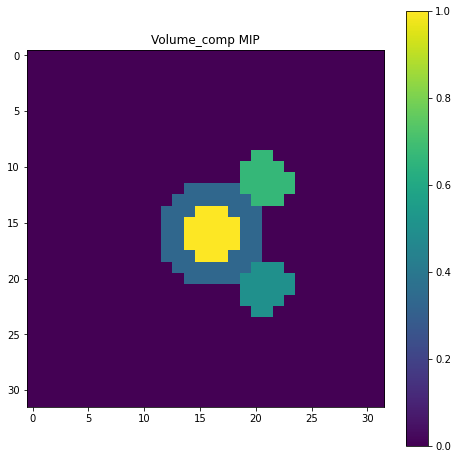

In [3]:
nx = 32
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0], [0,0,3]])
radii = np.array([3, 1.5, 1.5, 1.5])
intensities = np.array([10,15,20, 20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

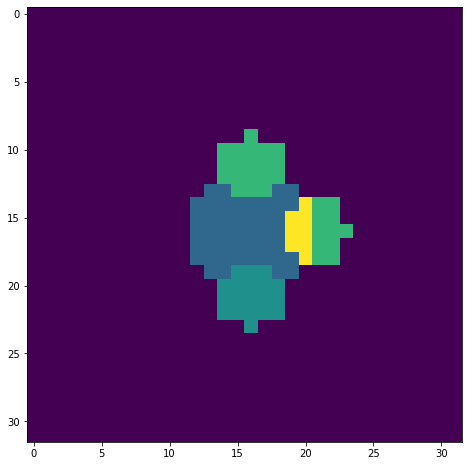

In [4]:
mip_y(vol)

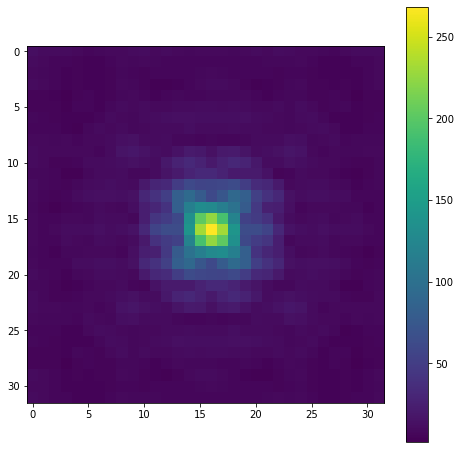

In [5]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [6]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


Generate projections (in Fourier domain)

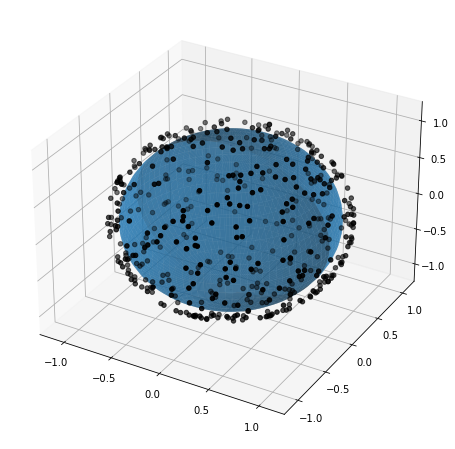

In [7]:
# Orientations
N = 4000

#s = 0.05
s = 0.1
angles_true = generate_uniform_orientations(N)
#jnp.array(np.random.rand(N,3))*jnp.pi*2

#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
#angles_true = s*np.random.randn(int(N),3)
#angles_true = np.concatenate([s*np.random.randn(2250,3), 
#                             s*np.random.randn(2250,3)+np.pi*2/3, 
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
#np.random.shuffle(angles_true)
#angles_true = jnp.array(angles_true)

#angles_true = np.zeros([N,3])
#angles_true[:,1] = s*np.random.randn(N) - np.pi/2
#angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

In [8]:
angles_true.shape

(4000, 3)

3.9437596797943115
0.40079505294596146


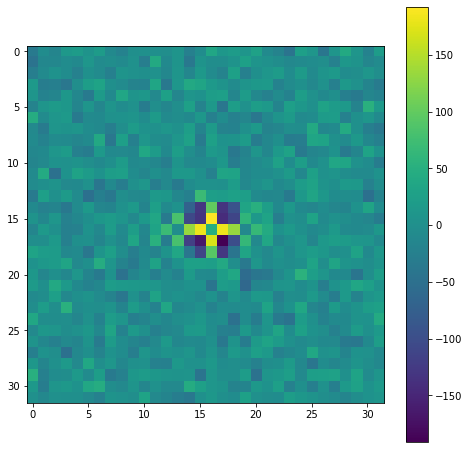

In [9]:
radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

norm0 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

# Noise
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0) *0.1

norm1 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

print(time.time()-start)

#SNR
print(norm0/norm1)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

### Crop images and volume:

In [10]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32

if old_nx > 32:
    imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
    imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
    imgs = imgs.reshape(imgs.shape[0], nx*nx)
    #imgs2 = imgs2.reshape(imgs2.shape[0], nx*nx)

    vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

    y_grid = x_grid
    z_grid = x_grid

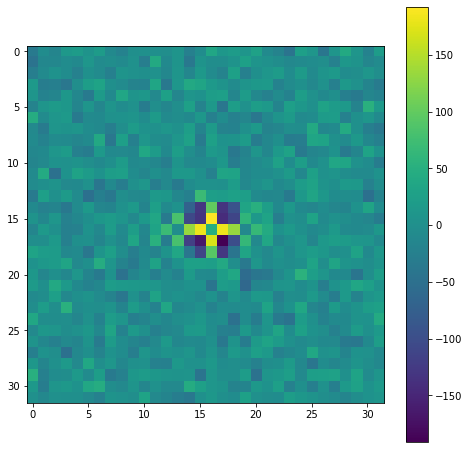

In [11]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

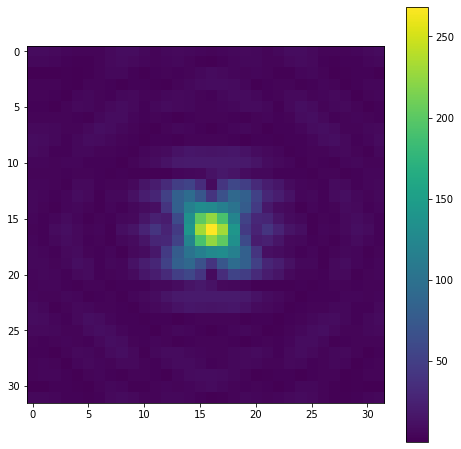

In [12]:
#mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:,:,0])))); plt.colorbar()

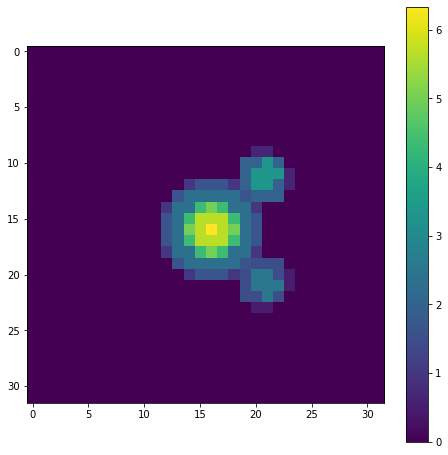

In [13]:
#mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:,:,0])))); plt.colorbar()

### Loss functions for the new dimension

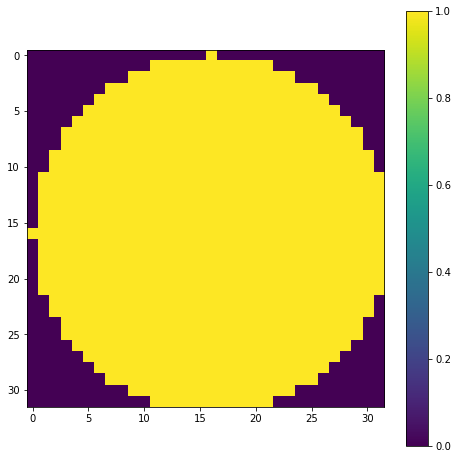

In [14]:
#alpha = 0.01
alpha = 0.001

radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [15]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
#ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

5.762449741363525
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [16]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0])
print(time.time()-start)
print(ll.shape)

2.4566712379455566
(32, 32, 32)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [17]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

3.8075966835021973
(32, 32, 32)


### Orientations

In [18]:
imgs.shape

(4000, 1024)

Iter  0
  Time orientations sampling = 5.147778272628784
  cg iter 0 ||r|| = 3.0423381368732816
  cg iter 50 ||r|| = 0.009602623253163342
  cg iter 100 ||r|| = 0.00011303085295411444
  cg iter 150 ||r|| = 0.0005042802588447141
  cg iter 200 ||r|| = 0.0017561596826900841
  cg iter 250 ||r|| = 0.004662570506551167
  Time cg = 8.815759897232056


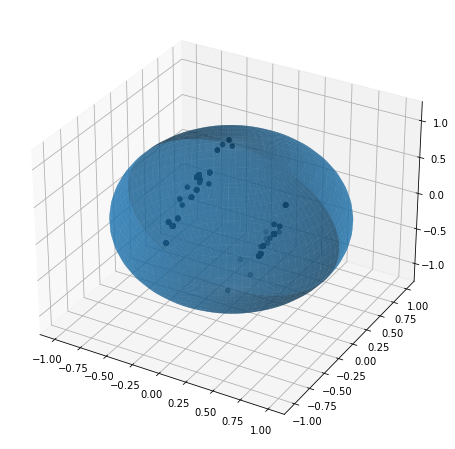

Iter  1
  Time orientations sampling = 2.6901891231536865
  cg iter 0 ||r|| = 0.8116050806126924
  cg iter 50 ||r|| = 0.0029887526875206068
  cg iter 100 ||r|| = 0.004586846259409449
  cg iter 150 ||r|| = 0.0045416768914461085
  cg iter 200 ||r|| = 0.0011345794536010917
  cg iter 250 ||r|| = 0.001954538016124749
  Time cg = 10.308141946792603
Iter  2
  Time orientations sampling = 2.1619760990142822
  cg iter 0 ||r|| = 1.3978965335765132
  cg iter 50 ||r|| = 0.0033324129481568823
  cg iter 100 ||r|| = 0.0020773071205857432
  cg iter 150 ||r|| = 0.0019077133243240463
  cg iter 200 ||r|| = 0.0009710580877242018
  cg iter 250 ||r|| = 0.0005549250288771448
  Time cg = 7.128877878189087
Iter  3
  Time orientations sampling = 2.267153024673462
  cg iter 0 ||r|| = 1.0378015485428682
  cg iter 50 ||r|| = 0.0058241730242305076
  cg iter 100 ||r|| = 0.0008561805980523478
  cg iter 150 ||r|| = 0.0014542779381050614
  cg iter 200 ||r|| = 0.00041752569323962214
  cg iter 250 ||r|| = 0.0003396098971

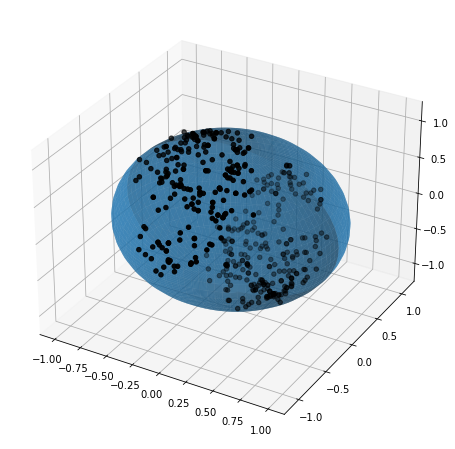

Iter  5
  Time orientations sampling = 2.7455310821533203
  cg iter 0 ||r|| = 0.6930105350838168
  cg iter 50 ||r|| = 0.004824227869586627
  cg iter 100 ||r|| = 0.0010187122629315161
  cg iter 150 ||r|| = 0.0004960078927642815
  cg iter 200 ||r|| = 0.0003609629433733208
  cg iter 250 ||r|| = 0.00020692301059883016
  Time cg = 11.607096910476685
Iter  6
  Time orientations sampling = 2.164066791534424
  cg iter 0 ||r|| = 0.7094506067892431
  cg iter 50 ||r|| = 0.002155839656426209
  cg iter 100 ||r|| = 0.0005333963821743935
  cg iter 150 ||r|| = 0.00022281811266984454
  cg iter 200 ||r|| = 0.00016153344756569303
  cg iter 250 ||r|| = 0.00017293829133027138
  Time cg = 6.797590494155884
Iter  7
  Time orientations sampling = 2.4756393432617188
  cg iter 0 ||r|| = 0.6933430294777686
  cg iter 50 ||r|| = 0.0010601621859526922
  cg iter 100 ||r|| = 0.00034348864671677885
  cg iter 150 ||r|| = 0.00023236962196074306
  cg iter 200 ||r|| = 0.00020605043736013145
  cg iter 250 ||r|| = 0.0001585

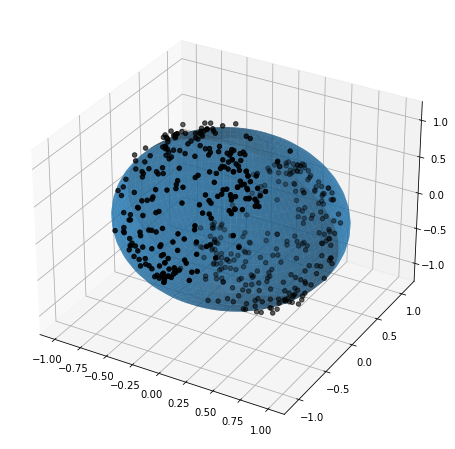

Iter  9
  Time orientations sampling = 2.7811949253082275
  cg iter 0 ||r|| = 0.4374788504789698
  cg iter 50 ||r|| = 0.0008290827650865242
  cg iter 100 ||r|| = 0.0003395841494548217
  cg iter 150 ||r|| = 0.00028410885353605714
  cg iter 200 ||r|| = 0.00018390949457969507
  cg iter 250 ||r|| = 0.0002717138735581863
  Time cg = 11.872928857803345
Iter  10
  Time orientations sampling = 2.181442975997925
  cg iter 0 ||r|| = 0.40647102486991127
  cg iter 50 ||r|| = 0.001365762347479308
  cg iter 100 ||r|| = 0.0002712534355396058
  cg iter 150 ||r|| = 0.0003197470153714323
  cg iter 200 ||r|| = 0.0002678869313426656
  cg iter 250 ||r|| = 0.00019346895093833537
  Time cg = 7.564068794250488
Iter  11
  Time orientations sampling = 2.1429190635681152
  cg iter 0 ||r|| = 0.40338775308403524
  cg iter 50 ||r|| = 0.0008232871592903419
  cg iter 100 ||r|| = 0.0003696564147215834
  cg iter 150 ||r|| = 0.0002477873725172899
  cg iter 200 ||r|| = 0.00022936219326917927
  cg iter 250 ||r|| = 0.00016

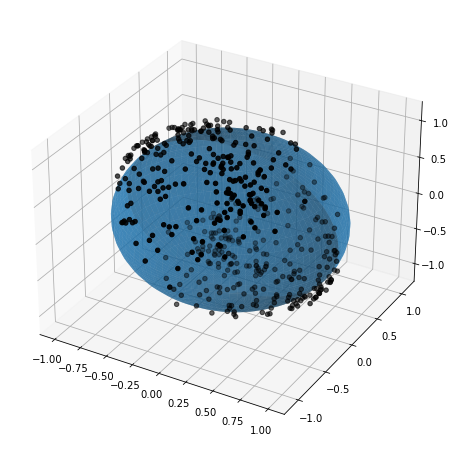

Iter  13
  Time orientations sampling = 2.1357502937316895
  cg iter 0 ||r|| = 0.4286368050131477
  cg iter 50 ||r|| = 0.0011160301435693566
  cg iter 100 ||r|| = 0.00047787368108989815
  cg iter 150 ||r|| = 0.0001920788623904985
  cg iter 200 ||r|| = 0.0002060359052810195
  cg iter 250 ||r|| = 0.00015238107856352379
  Time cg = 7.327686071395874
Iter  14
  Time orientations sampling = 2.1649293899536133
  cg iter 0 ||r|| = 0.4371237629945521
  cg iter 50 ||r|| = 0.0009073175884804482
  cg iter 100 ||r|| = 0.0003034982693938564
  cg iter 150 ||r|| = 0.0002109860341669819
  cg iter 200 ||r|| = 0.00017229933350795728
  cg iter 250 ||r|| = 0.0001629237189889483
  Time cg = 7.854006290435791
Iter  15
  Time orientations sampling = 2.1103296279907227
  cg iter 0 ||r|| = 0.4505756263875196
  cg iter 50 ||r|| = 0.0007172837246419993
  cg iter 100 ||r|| = 0.00019415062044871384
  cg iter 150 ||r|| = 0.00016470021358469617
  cg iter 200 ||r|| = 0.0001429703843958784
  cg iter 250 ||r|| = 0.0001

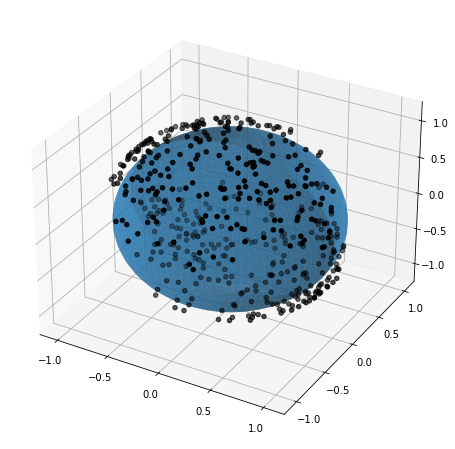

Iter  17
  Time orientations sampling = 3.039456605911255
  cg iter 0 ||r|| = 0.3466173406765529
  cg iter 50 ||r|| = 0.00048084301958126207
  cg iter 100 ||r|| = 0.00019011091232875143
  cg iter 150 ||r|| = 0.00012049704532837285
  cg iter 200 ||r|| = 9.130365860707558e-05
  cg iter 250 ||r|| = 9.152650191269239e-05
  Time cg = 13.960291385650635
Iter  18
  Time orientations sampling = 2.267550230026245
  cg iter 0 ||r|| = 0.350464613656543
  cg iter 50 ||r|| = 0.00041043902155857564
  cg iter 100 ||r|| = 0.00015706249191506036
  cg iter 150 ||r|| = 0.00016549720467726756
  cg iter 200 ||r|| = 0.00011926291283431039
  cg iter 250 ||r|| = 0.00011522326500887019
  Time cg = 8.450945138931274
Iter  19
  Time orientations sampling = 2.2301623821258545
  cg iter 0 ||r|| = 0.35052432044824183
  cg iter 50 ||r|| = 0.0003090980640450722
  cg iter 100 ||r|| = 0.00014863151945901625
  cg iter 150 ||r|| = 0.00012086940010042608
  cg iter 200 ||r|| = 0.00011480430912583347
  cg iter 250 ||r|| = 6

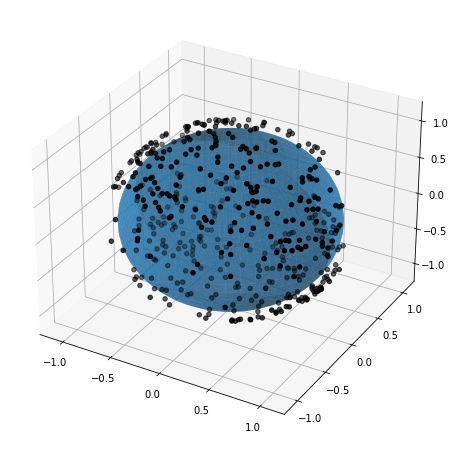

Iter  21
  Time orientations sampling = 3.0887112617492676
  cg iter 0 ||r|| = 0.26330330623709586
  cg iter 50 ||r|| = 0.00013531648397152943
  cg iter 100 ||r|| = 6.665043932111376e-05
  cg iter 150 ||r|| = 5.536590276015796e-05
  cg iter 200 ||r|| = 4.5041626814684634e-05
  cg iter 250 ||r|| = 3.598210173973462e-05
  Time cg = 14.148653984069824
Iter  22
  Time orientations sampling = 2.2131869792938232
  cg iter 0 ||r|| = 0.2606721785971506
  cg iter 50 ||r|| = 9.532088417117932e-05
  cg iter 100 ||r|| = 5.601125784985429e-05
  cg iter 150 ||r|| = 4.27966391071052e-05
  cg iter 200 ||r|| = 3.563614318420455e-05
  cg iter 250 ||r|| = 3.18794765227045e-05
  Time cg = 9.669642686843872
Iter  23
  Time orientations sampling = 2.1672000885009766
  cg iter 0 ||r|| = 0.2553179911453212
  cg iter 50 ||r|| = 0.00016210402076528678
  cg iter 100 ||r|| = 8.685719662057053e-05
  cg iter 150 ||r|| = 6.515614245113614e-05
  cg iter 200 ||r|| = 4.1809047730832144e-05
  cg iter 250 ||r|| = 3.85456

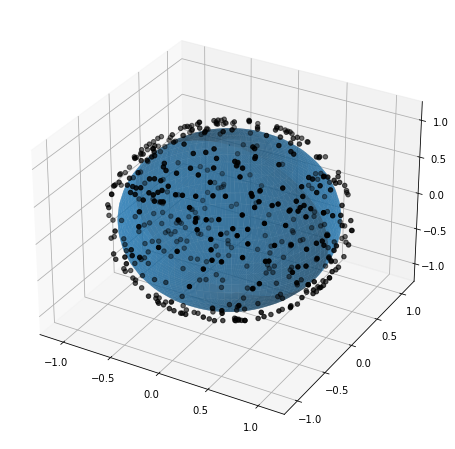

Iter  25
  Time orientations sampling = 3.2402751445770264
  cg iter 0 ||r|| = 0.19541027205099795
  cg iter 50 ||r|| = 7.521117908256268e-05
  cg iter 100 ||r|| = 5.398620658186638e-05
  cg iter 150 ||r|| = 4.649363546934483e-05
  cg iter 200 ||r|| = 3.572164145919712e-05
  cg iter 250 ||r|| = 3.160250049136673e-05
  Time cg = 17.120854139328003
Iter  26
  Time orientations sampling = 2.316915512084961
  cg iter 0 ||r|| = 0.1952060047781721
  cg iter 50 ||r|| = 0.00010250274997856233
  cg iter 100 ||r|| = 5.4668242948445296e-05
  cg iter 150 ||r|| = 4.634784691803722e-05
  cg iter 200 ||r|| = 4.428828209239906e-05
  cg iter 250 ||r|| = 2.7349074204023177e-05
  Time cg = 11.619758605957031
Iter  27
  Time orientations sampling = 2.3440442085266113
  cg iter 0 ||r|| = 0.1952661211917491
  cg iter 50 ||r|| = 9.68954559924705e-05
  cg iter 100 ||r|| = 4.902691934160004e-05
  cg iter 150 ||r|| = 4.0556937142687896e-05
  cg iter 200 ||r|| = 3.9564633130348966e-05
  cg iter 250 ||r|| = 2.687

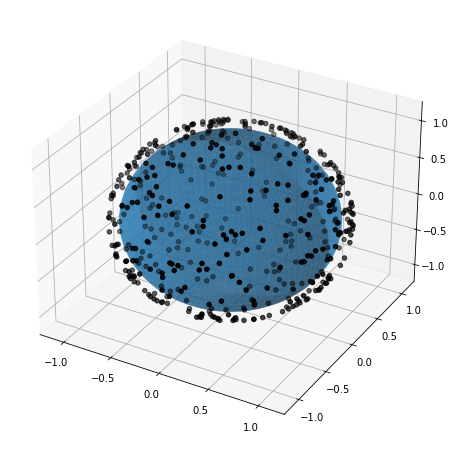

Iter  29
  Time orientations sampling = 3.149094343185425
  cg iter 0 ||r|| = 0.15829853293577253
  cg iter 50 ||r|| = 0.00010732951635763112
  cg iter 100 ||r|| = 5.302399838139325e-05
  cg iter 150 ||r|| = 3.620248650138866e-05
  cg iter 200 ||r|| = 3.4197872480019585e-05
  cg iter 250 ||r|| = 3.1120385466936914e-05
  Time cg = 18.493544578552246
Iter  30
  Time orientations sampling = 2.311645269393921
  cg iter 0 ||r|| = 0.15839922999767453
  cg iter 50 ||r|| = 0.00011711992886211761
  cg iter 100 ||r|| = 6.777787845821575e-05
  cg iter 150 ||r|| = 5.510261931061403e-05
  cg iter 200 ||r|| = 3.864084337442057e-05
  cg iter 250 ||r|| = 3.515834701724403e-05
  Time cg = 13.355861186981201
Iter  31
  Time orientations sampling = 2.811616897583008
  cg iter 0 ||r|| = 0.15850054780272851
  cg iter 50 ||r|| = 0.00010677710498127145
  cg iter 100 ||r|| = 6.760768299585557e-05
  cg iter 150 ||r|| = 5.020488823313028e-05
  cg iter 200 ||r|| = 4.177194955847403e-05
  cg iter 250 ||r|| = 3.74

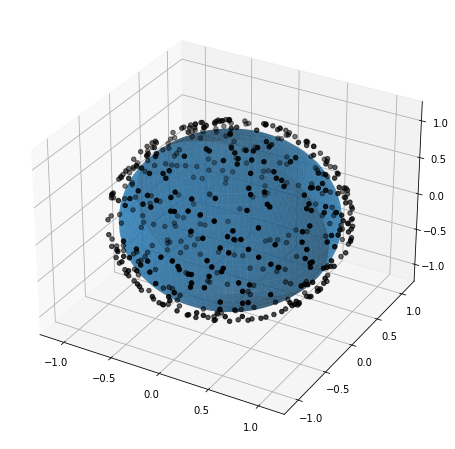

Iter  33
  Time orientations sampling = 3.295466661453247
  cg iter 0 ||r|| = 0.13110044874632001
  cg iter 50 ||r|| = 0.00011651292716995576
  cg iter 100 ||r|| = 6.87061829178315e-05
  cg iter 150 ||r|| = 6.402355096611406e-05
  cg iter 200 ||r|| = 4.9201959233285005e-05
  cg iter 250 ||r|| = 3.4488400772190505e-05
  Time cg = 21.37286114692688
Iter  34
  Time orientations sampling = 2.9070098400115967
  cg iter 0 ||r|| = 0.13111002521613607
  cg iter 50 ||r|| = 0.00010948911795672157
  cg iter 100 ||r|| = 6.441085041590477e-05
  cg iter 150 ||r|| = 4.147587997579668e-05
  cg iter 200 ||r|| = 4.497283532598415e-05
  cg iter 250 ||r|| = 3.177701776719438e-05
  Time cg = 16.325139045715332
Iter  35
  Time orientations sampling = 2.471909761428833
  cg iter 0 ||r|| = 0.13123517203147883
  cg iter 50 ||r|| = 9.897694573837327e-05
  cg iter 100 ||r|| = 5.804716810575869e-05
  cg iter 150 ||r|| = 5.725200730875873e-05
  cg iter 200 ||r|| = 3.836918471379227e-05
  cg iter 250 ||r|| = 3.6231

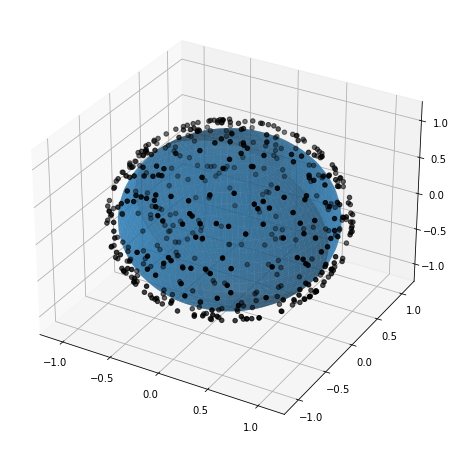

Iter  37
  Time orientations sampling = 3.7641124725341797
  cg iter 0 ||r|| = 0.11055454749656055
  cg iter 50 ||r|| = 9.516302878237119e-05
  cg iter 100 ||r|| = 5.4160691314519366e-05
  cg iter 150 ||r|| = 4.55485620736604e-05
  cg iter 200 ||r|| = 3.850032337570061e-05
  cg iter 250 ||r|| = 2.9371742879332357e-05
  Time cg = 22.321698904037476
Iter  38
  Time orientations sampling = 2.338118076324463
  cg iter 0 ||r|| = 0.11072046574585372
  cg iter 50 ||r|| = 9.103640670215182e-05
  cg iter 100 ||r|| = 7.027105438898713e-05
  cg iter 150 ||r|| = 4.6421098015139775e-05
  cg iter 200 ||r|| = 4.533709501517852e-05
  cg iter 250 ||r|| = 3.0309065049607876e-05
  Time cg = 17.67755365371704
Iter  39
  Time orientations sampling = 2.414996862411499
  cg iter 0 ||r|| = 0.11079401446475114
  cg iter 50 ||r|| = 8.889091161557317e-05
  cg iter 100 ||r|| = 6.296924554542255e-05
  cg iter 150 ||r|| = 4.476483342146892e-05
  cg iter 200 ||r|| = 3.7580444157316486e-05
  cg iter 250 ||r|| = 2.796

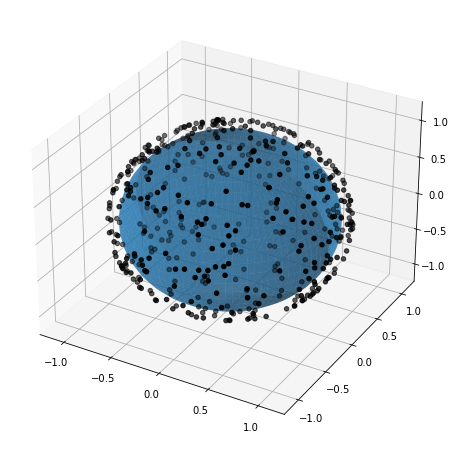

Iter  41
  Time orientations sampling = 3.508376359939575
  cg iter 0 ||r|| = 0.08141725058899918
  cg iter 50 ||r|| = 9.52081034775971e-05
  cg iter 100 ||r|| = 4.8234725894697425e-05
  cg iter 150 ||r|| = 3.812154799792073e-05
  cg iter 200 ||r|| = 3.512852642047063e-05
  cg iter 250 ||r|| = 2.780807610826341e-05
  Time cg = 28.521835327148438
Iter  42
  Time orientations sampling = 2.4480881690979004
  cg iter 0 ||r|| = 0.08149362856711734
  cg iter 50 ||r|| = 9.0452432427163e-05
  cg iter 100 ||r|| = 6.6796533927108e-05
  cg iter 150 ||r|| = 4.533490322659866e-05
  cg iter 200 ||r|| = 3.4945494970774936e-05
  cg iter 250 ||r|| = 3.6931371362551695e-05
  Time cg = 24.151307582855225
Iter  43
  Time orientations sampling = 2.3908727169036865
  cg iter 0 ||r|| = 0.08141584781828239
  cg iter 50 ||r|| = 9.979812019115767e-05
  cg iter 100 ||r|| = 5.661276411577087e-05
  cg iter 150 ||r|| = 4.662718014665987e-05
  cg iter 200 ||r|| = 3.742144897188669e-05
  cg iter 250 ||r|| = 3.6482000

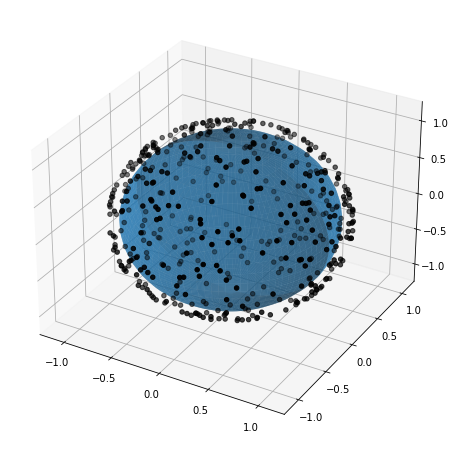

Iter  45
  Time orientations sampling = 3.6799259185791016
  cg iter 0 ||r|| = 0.07100957802357218
  cg iter 50 ||r|| = 0.00012197960166866676
  cg iter 100 ||r|| = 6.349407576332004e-05
  cg iter 150 ||r|| = 4.3749178488938376e-05
  cg iter 200 ||r|| = 4.585898681664137e-05
  cg iter 250 ||r|| = 3.446882360844933e-05
  Time cg = 32.37192392349243
Iter  46
  Time orientations sampling = 2.3367154598236084
  cg iter 0 ||r|| = 0.07115711252603883
  cg iter 50 ||r|| = 9.935987832528325e-05
  cg iter 100 ||r|| = 6.51026771249749e-05
  cg iter 150 ||r|| = 6.29241577262008e-05
  cg iter 200 ||r|| = 3.892053911743059e-05
  cg iter 250 ||r|| = 3.1389322983121836e-05
  Time cg = 28.34173011779785
Iter  47
  Time orientations sampling = 2.3550329208374023
  cg iter 0 ||r|| = 0.07098718327342866
  cg iter 50 ||r|| = 9.292773251794627e-05
  cg iter 100 ||r|| = 6.960426707403794e-05
  cg iter 150 ||r|| = 4.506495637399007e-05
  cg iter 200 ||r|| = 4.4724109974455236e-05
  cg iter 250 ||r|| = 4.1105

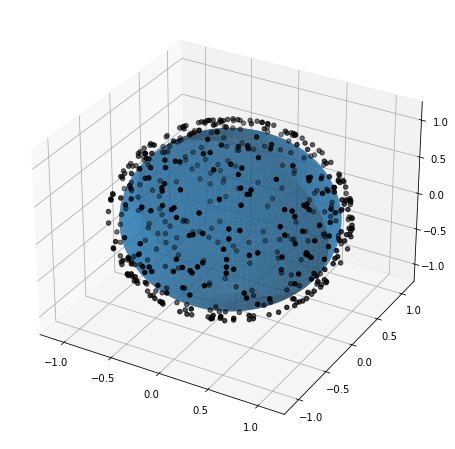

Iter  49
  Time orientations sampling = 3.33280086517334
  cg iter 0 ||r|| = 0.06242418819037925
  cg iter 50 ||r|| = 0.0001209564620487271
  cg iter 100 ||r|| = 5.626328951936718e-05
  cg iter 150 ||r|| = 5.001052376840539e-05
  cg iter 200 ||r|| = 3.376676047297556e-05
  cg iter 250 ||r|| = 3.3575737937926615e-05
  Time cg = 32.364206075668335


In [19]:
from src.ab_initio import ab_initio

N_samples = 40000
N_iter = 100
N_cg_iter = 300
dr = 0.05
radius = 0.1
alpha = 0

out_dir = '../data/'
imgs = imgs.reshape([N, nx*nx])
vcg = ab_initio(project, imgs, shifts_true, ctf_params, x_grid, N_iter, N_cg_iter, N_samples, radius, dr, alpha, 'tri', False, True, True, out_dir)

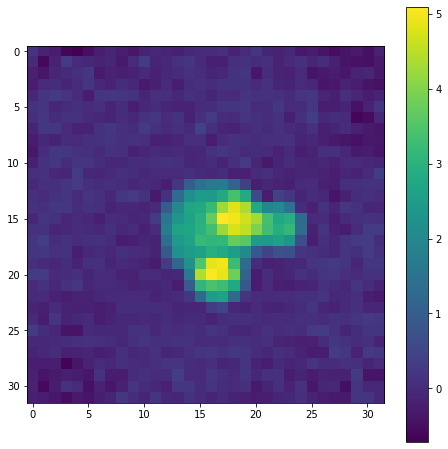

In [20]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[0,:,:])))); plt.colorbar()

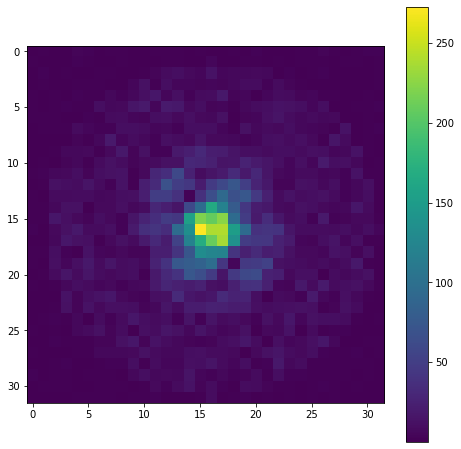

In [21]:
plt.imshow(jnp.abs(jnp.fft.fftshift(vcg[:,:,0]))); plt.colorbar()

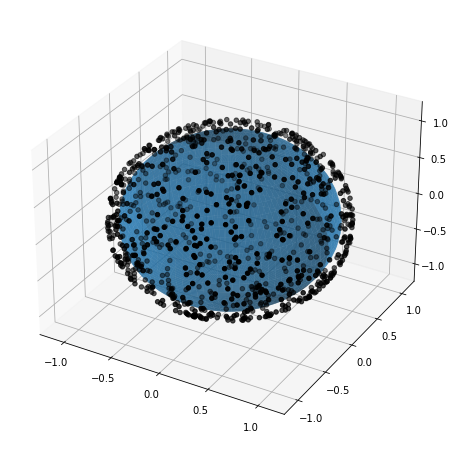

In [22]:
#angles_r = generate_uniform_orientations(400)
plot_angles(angles_true[:1000])

## Optimization with respect to volume

### CG - applied to two halves of the data

In [25]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 500

N2 = jnp.floor(N/2).astype(jnp.int64)
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 0.06268530087936473
  cg iter 50 ||r|| = 0.0001071211767697443
  cg iter 100 ||r|| = 6.147088776653945e-05
  cg iter 150 ||r|| = 6.402246206437615e-05
  cg iter 200 ||r|| = 4.268924389310204e-05
  cg iter 250 ||r|| = 4.162939781052535e-05
  cg iter 300 ||r|| = 3.2401721727483404e-05
  cg iter 350 ||r|| = 3.799932315430272e-05
  cg iter 400 ||r|| = 2.9342566400162206e-05
  cg iter 450 ||r|| = 2.8510850436484787e-05


In [26]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 0.06295050660572052
  cg iter 50 ||r|| = 9.024988878096568e-05
  cg iter 100 ||r|| = 4.648784470884987e-05
  cg iter 150 ||r|| = 4.0087735059284285e-05
  cg iter 200 ||r|| = 3.178357946322257e-05
  cg iter 250 ||r|| = 2.500523467024185e-05
  cg iter 300 ||r|| = 2.513130914932849e-05
  cg iter 350 ||r|| = 2.5238061398510623e-05
  cg iter 400 ||r|| = 2.1782719004277905e-05
  cg iter 450 ||r|| = 2.1868738222962514e-05


In [27]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

Relative error =  0.3304931601527718
Absolute error =  5.092693338912836


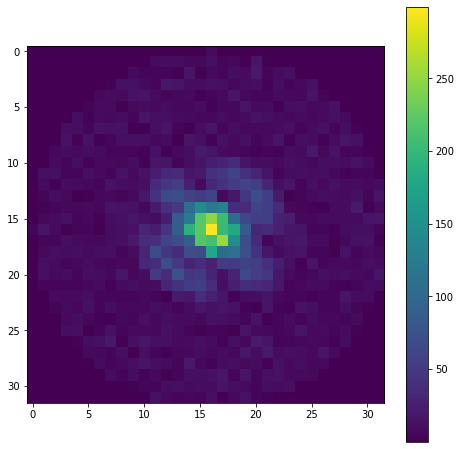

In [28]:
#mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; 
plt.imshow(jnp.abs(jnp.fft.fftshift((vcg1[0,:,:])))) ; 
plt.colorbar()

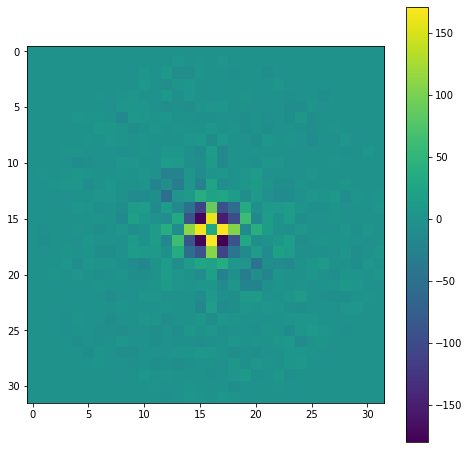

In [29]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

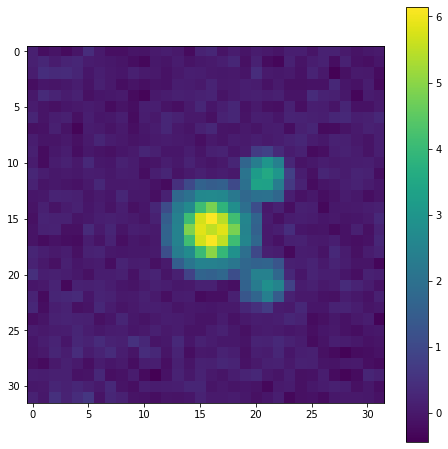

In [30]:
#mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[:,:,0]))))
plt.colorbar()
#plt.title('Reconstruction slice')

Text(0.5, 1.0, 'Reconstruction MIP')

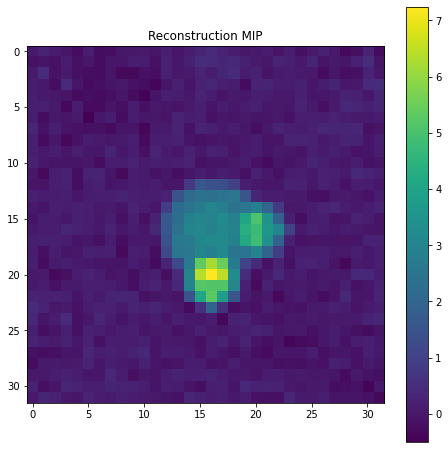

In [31]:
#mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2[0,:,:]))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

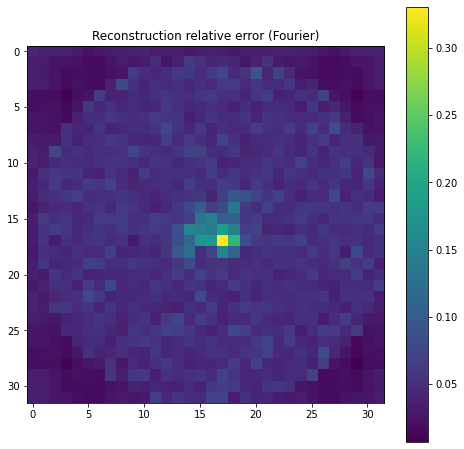

In [32]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

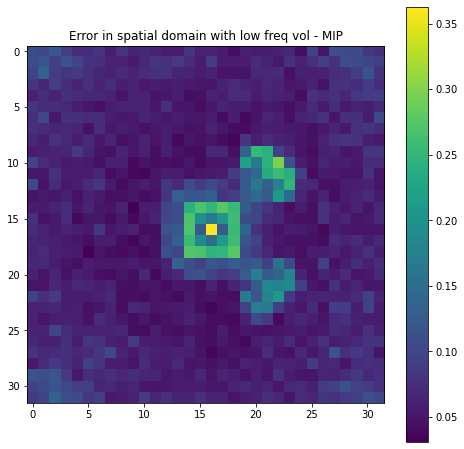

In [33]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

### FSC

In [34]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr = 0.05)

In [ ]:
points_v_tri = points_orientations_tri(angles_true[:int(N/2)], x_grid[1])
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow(jnp.fft.fftshift((points_v_tri[0,:,:]*mask[0,:,:]))); plt.colorbar()

In [ ]:
#res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
#plt.plot(res_spu, spu_nn)

### James

The mean is given by CG as applied above, in addition we need to calculate the variances.
The variances are given by the inverse of the gradient (AA) applied to diag(1), i.e. a volume with ones.

Looks good and agrees with counting the points above, but for whatever reason it's mirrored compared to above hmmm.

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.title("Mean")
plt.imshow((jnp.abs(jnp.fft.fftshift(vcg1[:,:,0])))); plt.colorbar()

#### Train/test stuff - something's wrong here

In [ ]:
res

In [ ]:
loss = []
for radius in res[1:]:
    mask = create_3d_mask(x_grid, (0,0,0),radius)
    mask_imgs = mask[0,:,:].reshape(1,-1)
    ll = loss_func_sum(vcg1 * mask, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:]*mask_imgs)   
    loss.append(ll)
    
loss = jnp.array(loss)

#plt.imshow(jnp.fft.fftshift(mask[:,:,0]))

In [ ]:
plt.plot(res[1:], loss)

### SGD

In [ ]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = vol_fourier + 0.1*v * mask
alpha = 10 # this alpha works well for full 128 x 128 x 128 volume with mask
batch_size = 2
N_iter = 1000  
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

In [ ]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

In [ ]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((v)))) ; plt.colorbar()

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

In [ ]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

In [ ]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')